# Inventory management project

## Data exploration and preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load data

df_infos = pd.read_csv("infos.csv", sep = "|")
df_items = pd.read_csv("items.csv", sep = "|")
df_orders = pd.read_csv("orders.csv.zip", sep = "|", compression="zip")

In [3]:
# fix datetime format for transaction time

df_orders['time'] = pd.to_datetime(df_orders['time'])

In [4]:
# in df_infos column promotion there are cells with more than one date, separated by a comma
# how many such are there?

(df_infos["promotion"].str.len() > 10).sum()

# 190
# I leave it as text for now, we should handle it later

190

In [5]:
df_infos["promotion"][df_infos["promotion"].str.len() > 10]

34       2018-07-01,2018-07-02,2018-07-13
74                  2018-07-05,2018-07-11
124                 2018-07-08,2018-07-13
125                 2018-07-05,2018-07-11
353                 2018-07-08,2018-07-11
                       ...               
9996                2018-07-02,2018-07-05
10093               2018-07-05,2018-07-09
10111    2018-07-04,2018-07-05,2018-07-06
10176               2018-07-01,2018-07-10
10318               2018-07-05,2018-07-06
Name: promotion, Length: 190, dtype: object

<Axes: ylabel='Frequency'>

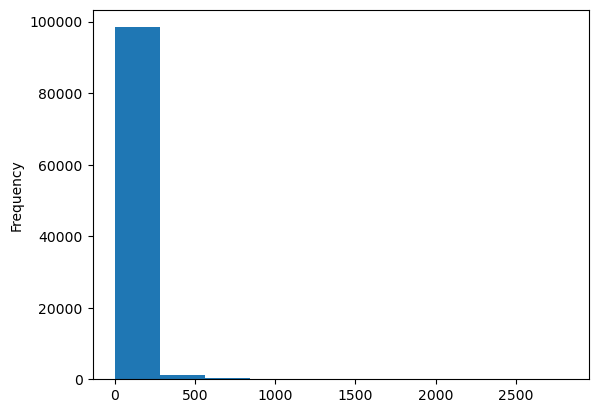

In [6]:
# when an item has been bought more than once in a day, in most cases, what transaction number per day are we talking about?

df_orders.groupby([df_orders['time'].dt.date, df_orders['itemID']])['order'].count().plot(kind='hist')

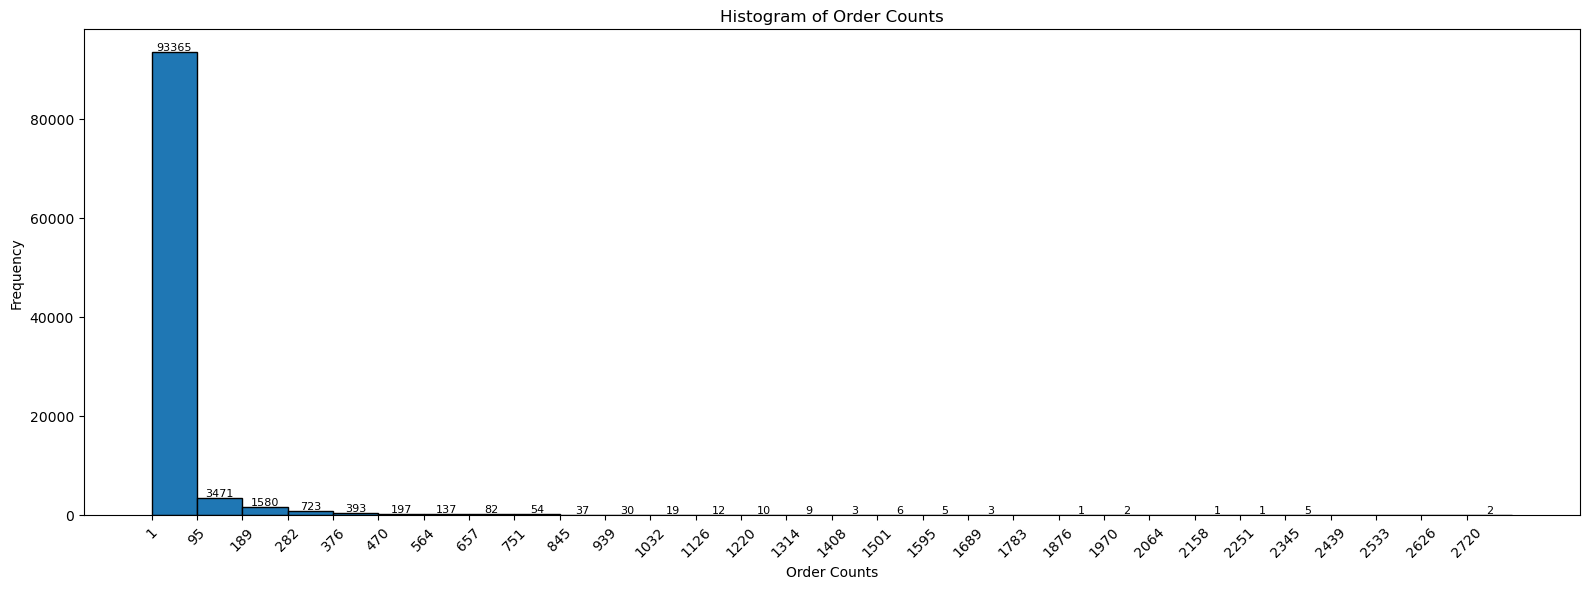

In [7]:
# Group and count orders
order_counts = df_orders.groupby([df_orders['time'].dt.date, df_orders['itemID']])['order'].count()

# Create the figure and axes with a wider size
plt.figure(figsize=(16, 6))  # Wider plot

# Plot histogram
ax = order_counts.plot(kind='hist', bins=30, edgecolor='black')

# Add value labels on top of bars
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=8)

# Set all xticks to be visible
bin_edges = ax.patches[0].get_x()
xticks = [patch.get_x() for patch in ax.patches]
ax.set_xticks(xticks)
ax.tick_params(axis='x', rotation=45)

plt.xlabel("Order Counts")
plt.ylabel("Frequency")
plt.title("Histogram of Order Counts")
plt.tight_layout()
plt.show()

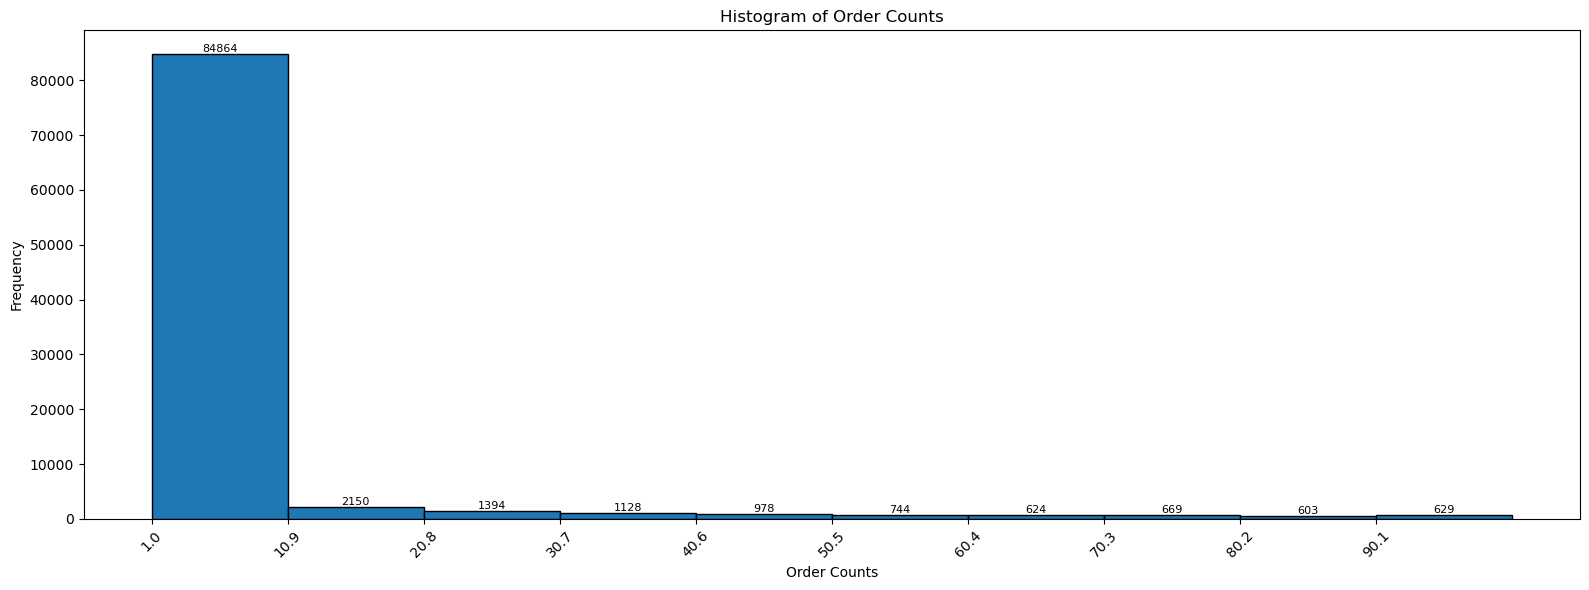

In [8]:
# Group and count orders
order_counts = order_counts[order_counts <= 100]

# Create the figure and axes with a wider size
plt.figure(figsize=(16, 6))  # Wider plot

# Plot histogram
ax = order_counts.plot(kind='hist', bins=10, edgecolor='black')

# Add value labels on top of bars
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=8)

# Set all xticks to be visible
bin_edges = ax.patches[0].get_x()
xticks = [patch.get_x() for patch in ax.patches]
ax.set_xticks(xticks)
ax.tick_params(axis='x', rotation=45)

plt.xlabel("Order Counts")
plt.ylabel("Frequency")
plt.title("Histogram of Order Counts")
plt.tight_layout()
plt.show()

In [9]:
# does df_infos, containing the promotions, contain unique item IDs or are they duplicated?
# I expect them to be unique

len(df_infos["itemID"]) == len(df_items)


True

In [10]:
df_infos["itemID"].isin(df_items["itemID"]).count() == len(df_infos["itemID"])

# it contains a row for each itemID

True

In [11]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181955 entries, 0 to 2181954
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   time        datetime64[ns]
 1   transactID  int64         
 2   itemID      int64         
 3   order       int64         
 4   salesPrice  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 83.2 MB


In [12]:
# before grouping on daily basis, it will be important for us to check
# whether a material has been sold on a different price in the same day

price_variations = (
    df_orders
    .assign(date=df_orders['time'].dt.date)
    .groupby(['itemID', 'date'])['salesPrice']
    .nunique()
    .reset_index(name='unique_price_count')
)


# Filter where price count > 1 (i.e., same item sold at multiple prices)
price_variations[price_variations['unique_price_count'] > 1]

# there is, it is most logical for these cases that we take average price for the day

,itemID,date,unique_price_count
82,6,2018-05-30,2
188,15,2018-01-27,2
381,27,2018-02-17,2
472,34,2018-05-03,2
521,35,2018-05-25,4
...,...,...,...
100002,10333,2018-06-29,2
100003,10334,2018-06-29,2
100097,10425,2018-06-27,2
100105,10431,2018-05-14,2


In [13]:
# add one column which is only with the date, no time

df_orders['date'] = df_orders['time'].dt.date

In [14]:
# are there order prices which are higher than the simulation price?

# Merge orders with simulation info by ItemID
df_temp = df_orders.merge(df_infos[['itemID', 'simulationPrice']], on='itemID', how='left')

# Check if salesPrice > simulationPrice
df_temp['price_higher_than_sim'] = df_temp['salesPrice'] > df_temp['simulationPrice']

# Find items where any salesPrice exceeds simulationPrice
(
    df_temp[df_temp['price_higher_than_sim']]
    .drop_duplicates(subset='itemID')
    [['itemID']]
)

# there are many

,itemID
19,4322
20,7975
22,5007
23,2013
27,529
...,...
2162508,7202
2165017,3850
2168870,6472
2174571,9908


In [15]:
# Step 1: Get the maximum price per itemID
max_price_per_item = df_orders.groupby('itemID')['salesPrice'].transform('max')

# Step 2: Compare each row's price to the max price for that item
df_orders['promotion'] = df_orders['salesPrice'] < max_price_per_item

# Step 3: Convert boolean to "yes"/"no"
df_orders['promotion'] = df_orders['promotion'].map({True: 'yes', False: 'no'})

In [16]:
# there seem to be 0 price transactions

len(df_orders[df_orders["salesPrice"]==0])/len(df_orders)*100

# they are 0.02% of all transactions, it is best to delete them instead of thinking how to handle them

df_orders = df_orders[df_orders["salesPrice"]!=0]

In [17]:
# in infos, we can add a column with discounted price where the presence of  discount is indicated
# it can be = the simulation price + the average % discount we see usually given from the orders table
# if the disctribution of the discounts is not too unstable

In [18]:
# how do discounts vary

df_discount_stats = df_orders[["itemID", "salesPrice", "promotion"]].copy()

df_discount_stats["maxPrice"] = df_orders.groupby("itemID")["salesPrice"].transform("max")

In [19]:
# how do discounts vary

df_discount_stats["discountAmount"] = round(df_discount_stats["maxPrice"] - df_discount_stats["salesPrice"], 2)

df_discount_stats["discountPerc"] = round(df_discount_stats["discountAmount"]/df_discount_stats["maxPrice"], 2)

In [20]:
# max and min % discount

print(max(df_discount_stats["discountPerc"]), min(df_discount_stats["discountPerc"][df_discount_stats["discountPerc"] != 0]))

0.95 0.01


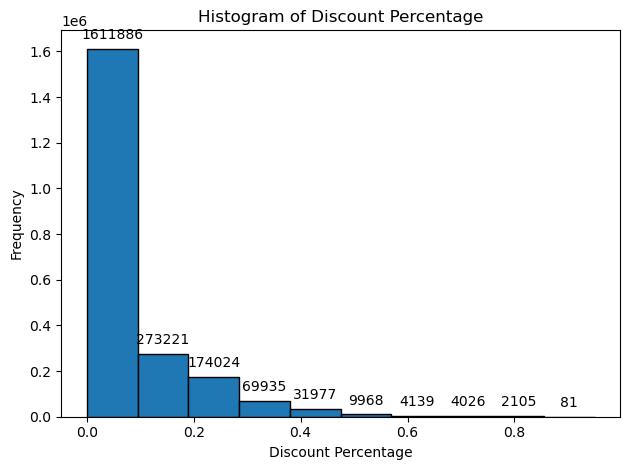

In [21]:
# Create the histogram and get the bars
ax = df_discount_stats["discountPerc"].plot(kind="hist", bins=10, edgecolor='black')

# Add value labels on top of each bar
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    xy=(patch.get_x() + patch.get_width() / 2, height), 
                    xytext=(0, 5),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.xlabel("Discount Percentage")
plt.ylabel("Frequency")
plt.title("Histogram of Discount Percentage")
plt.tight_layout()
plt.show()

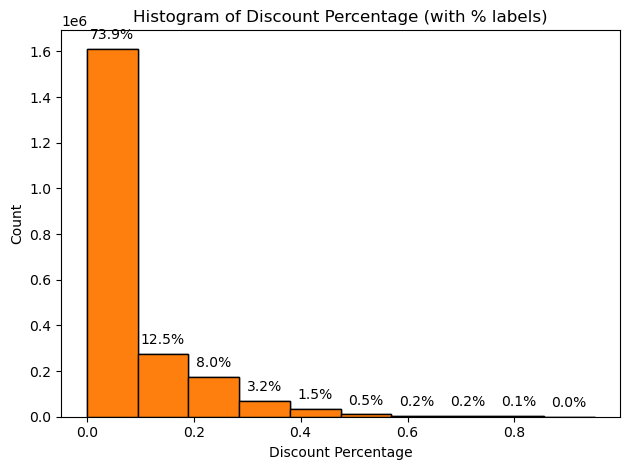

In [22]:
# Total number of observations
total = len(df_discount_stats["discountPerc"].dropna())

# Plot the histogram as density (normalized)
ax = df_discount_stats["discountPerc"].plot(kind="hist", bins=10, edgecolor='black', density=False)

# Get the actual bin heights (counts) to calculate percentages
counts, bins, patches = plt.hist(df_discount_stats["discountPerc"].dropna(), bins=10, edgecolor='black')

# Annotate bars with percentage labels
for count, patch in zip(counts, patches):
    percentage = 100 * count / total
    if count > 0:
        plt.annotate(f'{percentage:.1f}%', 
                     xy=(patch.get_x() + patch.get_width() / 2, count), 
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.xlabel("Discount Percentage")
plt.ylabel("Count")
plt.title("Histogram of Discount Percentage (with % labels)")
plt.tight_layout()
plt.show()

In [23]:
# looking at the skewed distribution, for getting an approximate discount percentage per item
# it would be better to use the median instead of the mean
# adding column for discounted price to table df_infos = simulation price - median discount for item

df_discount_stats["medianDiscPerc"] = round((
    df_discount_stats[df_discount_stats["discountAmount"] != 0]
    .groupby("itemID")["discountPerc"]
    .transform("median")
) ,2)

In [24]:
# adding column for discounted price to table df_infos = simulation price - median discount for item

df_infos = df_infos.merge(df_discount_stats[['itemID', 'medianDiscPerc']], on='itemID', how='left')

In [25]:
# adding column for discounted price to table df_infos = simulation price - median discount for item

df_infos["discountedPrice"] = np.where(
    df_infos["promotion"].notna(),
    round(df_infos["simulationPrice"] * (1 - df_infos["medianDiscPerc"]), 2),
    np.nan  # or just leave it to default if you prefer
)


## Aggregate orders and add variables

In [ ]:
# aggregate orders per day

df_orders_daily = (
    df_orders
    .groupby(['date', 'itemID'])
    .agg(
        total_orders=('order', 'sum'),
        avg_salesPrice=('salesPrice', 'mean')
    )
    .reset_index()
)

In [ ]:
# add masterdata to df_orders_daily

df_orders_daily = df_orders.merge(df_items, on='itemID', how='left')

In [ ]:
# add week day

df_orders_daily['weekday'] = df_orders_daily['time'].dt.weekday+1